# Step 4: Hypotheses 3

Video’s waarvan de comments een positief sentiment hebben, vertonen een significant hoger aantal views.

In [67]:
# Import standard libraries
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
# Get the data from the previous step
videos = pd.read_excel('../output/videos.xlsx', index_col='id')
comments = pd.read_excel('../output/comments.xlsx', index_col=0)

## 4.1 Data Exploration

### 4.1.1 Videos

In [33]:
# Explore the data structure for videos
videos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, KNNAUcLMJpo to C3INoqCqwjE
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                510 non-null    object 
 1   publish_date         510 non-null    object 
 2   duration             510 non-null    object 
 3   views                510 non-null    int64  
 4   likes                510 non-null    int64  
 5   dislikes             510 non-null    int64  
 6   shares               510 non-null    int64  
 7   comments             510 non-null    int64  
 8   engagement           510 non-null    float64
 9   views_24h            510 non-null    int64  
 10  views_1w             510 non-null    int64  
 11  views_2w             509 non-null    float64
 12  views_1m             510 non-null    int64  
 13  views_2m             509 non-null    float64
 14  views_3m             484 non-null    float64
 15  likes_24h            510 no

In [34]:
# Get a statistical summary of the video data
videos.describe()

,views,likes,dislikes,shares,comments,engagement,views_24h,views_1w,views_2w,views_1m,...,comments_2w,comments_1m,comments_2m,comments_3m,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,509.000000,510.000000,...,509.000000,510.000000,509.000000,484.000000,510.000000,510.000000,509.000000,510.000000,509.000000,484.000000
mean,9697.178431,98.452941,5.692157,150.772549,13.984314,2.557765,1466.223529,2835.847059,3261.092338,3660.982353,...,5.414538,5.886275,6.387033,7.084711,3.962490,3.326000,3.195363,3.070647,2.959430,2.873657
std,19792.876939,173.476146,11.468473,508.850088,30.230544,0.881494,1602.489446,3635.835643,4130.855539,4615.818106,...,6.015978,6.482772,7.724431,9.274682,1.693031,1.324181,1.238335,1.144629,1.055782,1.028733
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2759.000000,32.000000,1.000000,29.000000,2.000000,2.030000,612.000000,959.500000,1099.000000,1232.500000,...,2.000000,2.000000,2.000000,2.000000,2.665000,2.402500,2.300000,2.290000,2.250000,2.220000
50%,5208.500000,59.000000,3.000000,61.000000,6.000000,2.500000,934.000000,1704.000000,1998.000000,2265.500000,...,3.000000,4.000000,4.000000,4.000000,3.930000,3.350000,3.220000,3.155000,3.000000,2.955000
75%,10060.000000,110.750000,6.000000,136.250000,13.000000,3.097500,1668.500000,2985.500000,3321.000000,3914.000000,...,7.000000,7.750000,8.000000,9.000000,5.062500,4.180000,4.020000,3.790000,3.650000,3.542500
max,363712.000000,2795.000000,127.000000,8202.000000,332.000000,6.300000,13045.000000,40815.000000,41529.000000,42000.000000,...,55.000000,59.000000,84.000000,87.000000,10.230000,7.930000,7.690000,7.690000,6.660000,6.430000


In [35]:
# Show the first 10 videos
videos.head(10)

,title,publish_date,duration,views,likes,dislikes,shares,comments,engagement,views_24h,...,comments_2w,comments_1m,comments_2m,comments_3m,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m
id,,,,,,,,,,,,,,,,,,,,,
KNNAUcLMJpo,Veggie 🥕 of vlees 🍖?,2024-07-25T07:35:04Z,0:19,987,12,3,3,1,1.32,575,...,1.0,1,1.0,1.0,1.22,1.46,1.37,1.40,1.30,1.28
KCc98U0fVJ8,Zomerpodcast opnemen op het Nerdland Festival!...,2022-06-22T20:47:49Z,0:21,1011,21,1,1,0,2.08,206,...,0.0,0,0.0,0.0,1.94,1.76,1.65,1.76,2.01,1.86
bl9LxOG4kV8,Zitten we in een financiële bubbel? #WetenSNAP,2022-10-31T15:00:08Z,1:55,1763,28,0,9,1,2.16,502,...,1.0,1,1.0,1.0,3.59,2.67,2.45,2.29,2.25,2.26
fn1dz5Xez0E,Bestaan bijna - doodervaringen echt?,2024-11-02T13:30:21Z,0:41,846,25,0,4,1,3.55,447,...,1.0,1,1.0,1.0,4.03,4.17,4.04,4.03,3.86,3.78
2Uw331k0AdE,Leer je beter wanneer je beweegt?,2024-09-12T14:29:09Z,0:34,1304,38,1,8,1,3.53,705,...,1.0,1,1.0,1.0,3.83,3.77,3.72,3.71,3.59,3.69
9wj7AkDaH3E,Dit element is cruciaal voor de geestelijke ge...,2024-12-14T15:00:16Z,0:32,755,20,0,1,0,2.78,531,...,0.0,0,0.0,NaN,2.82,2.82,2.74,2.68,2.79,NaN
GqVjUd2vUjM,Wat maakt de Poolster zo bijzonder?,2024-09-09T13:12:26Z,0:22,933,22,0,7,1,3.22,483,...,1.0,1,1.0,1.0,4.14,3.40,3.37,3.37,3.30,3.23
FXhLtCTX7_o,Twee dingen die jij kan doen als je buur net i...,2024-12-20T15:00:25Z,0:33,616,11,0,3,0,2.27,430,...,0.0,0,0.0,NaN,1.40,2.00,2.07,2.01,2.14,NaN
RIkqRlCa3Ps,Kan jij dit wiskunderaadsel oplossen?,2024-09-23T14:32:13Z,0:35,1303,16,2,3,3,1.53,697,...,2.0,2,2.0,2.0,1.72,1.54,1.50,1.53,1.36,1.42


### 4.1.2 Comments

In [36]:
# Explore the data structure for comments
comments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6594 entries, 0 to 6593
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6594 non-null   object
 1   comment_id         6594 non-null   object
 2   parent_comment_id  2536 non-null   object
 3   author             6594 non-null   object
 4   published_at       6594 non-null   object
 5   like_count         6594 non-null   int64 
 6   comment_nl         6590 non-null   object
 7   is_reply           6594 non-null   bool  
 8   comment_en         6549 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 470.1+ KB


In [37]:
# Show the first 10 comments
comments.head(10)

,id,comment_id,parent_comment_id,author,published_at,like_count,comment_nl,is_reply,comment_en
0,KNNAUcLMJpo,Ugzc2tT_j0zGzUcmI-d4AaABAg,NaN,User1,2024-07-30T12:13:39Z,0,Je hebt het helemaal niet nodig😅. Ik heb altij...,False,You don't need it at all😅. I have always had s...
1,bl9LxOG4kV8,UgwIEstA0YJWflmon2p4AaABAg,NaN,User2,2022-10-31T15:33:50Z,1,besluiten te scheiden te scheiden omdat het ni...,False,decide to separate because it is no longer liv...
2,fn1dz5Xez0E,UgwtObJVEW2m0wx_aHt4AaABAg,NaN,User3,2024-11-09T17:31:37Z,2,Geniet van je leven het kan elk moment gedaan ...,False,Enjoy your life it may be done any time 💀
3,2Uw331k0AdE,UgwpwYoe9VFw21f4lsZ4AaABAg,NaN,User3,2024-09-12T14:30:07Z,1,Geweldig\nDie studenten toch.,False,Great\nThose students anyway.
4,GqVjUd2vUjM,UgzxWKVSjKn9R7mQDqt4AaABAg,NaN,User3,2024-09-09T14:25:07Z,0,Keileuk,False,Keogeuk
5,RIkqRlCa3Ps,UgwOP4oy5UFYKqYR2Bp4AaABAg,NaN,User4,2024-09-25T21:34:47Z,3,Ik snap de vraag niet,False,I don't understand the question
6,RIkqRlCa3Ps,UgwxRpvYPkIdGMUnMzh4AaABAg,NaN,User3,2024-09-23T14:56:17Z,0,Ik wist het niet. ic beñ domm,False,I didn't know. IC Beñ Domm
7,RIkqRlCa3Ps,UgwxRpvYPkIdGMUnMzh4AaABAg.A8jON9rm52rA8lDfsSs3Ue,UgwxRpvYPkIdGMUnMzh4AaABAg,@UniversiteitvanVlaanderen,2024-09-24T08:01:20Z,1,Absoluut niet! Want dit is top-wiskunde. En co...,True,Absolutely not! Because this is top mathematic...
8,rlZFwSR7cHQ,Ugzj4wZqZ0wvCnOHcep4AaABAg,NaN,User5,2024-03-18T13:35:33Z,0,Nou ik heb nooit gestudeerd. Maar krijg toch n...,False,Well I never studied. But never get a woman. S...
9,vmyjXBrq2FY,UgxnZMn8G47jpxkbgNV4AaABAg,NaN,User3,2024-12-19T08:33:33Z,1,"Mmmmmmm antibiotica, lekker",False,"Mmmmmmm antibiotics, tasty"


## 4.2 Data Preparation

In [38]:
# Create the SentimentIntensityAnalyzer object
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tvercamer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
# Use VADER to determine the sentiment of the comments
comments['sentiment_score'] = comments['comment_en'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
comments['sentiment_label'] = comments['sentiment_score'].apply(lambda x: 'positief' if x > 0.05 else ('negatief' if x < -0.05 else 'neutraal'))
comments.head()

,id,comment_id,parent_comment_id,author,published_at,like_count,comment_nl,is_reply,comment_en,sentiment_score,sentiment_label
0,KNNAUcLMJpo,Ugzc2tT_j0zGzUcmI-d4AaABAg,NaN,User1,2024-07-30T12:13:39Z,0,Je hebt het helemaal niet nodig😅. Ik heb altij...,False,You don't need it at all😅. I have always had s...,0.7003,positief
1,bl9LxOG4kV8,UgwIEstA0YJWflmon2p4AaABAg,NaN,User2,2022-10-31T15:33:50Z,1,besluiten te scheiden te scheiden omdat het ni...,False,decide to separate because it is no longer liv...,0.5499,positief
2,fn1dz5Xez0E,UgwtObJVEW2m0wx_aHt4AaABAg,NaN,User3,2024-11-09T17:31:37Z,2,Geniet van je leven het kan elk moment gedaan ...,False,Enjoy your life it may be done any time 💀,0.4939,positief
3,2Uw331k0AdE,UgwpwYoe9VFw21f4lsZ4AaABAg,NaN,User3,2024-09-12T14:30:07Z,1,Geweldig\nDie studenten toch.,False,Great\nThose students anyway.,0.6249,positief
4,GqVjUd2vUjM,UgzxWKVSjKn9R7mQDqt4AaABAg,NaN,User3,2024-09-09T14:25:07Z,0,Keileuk,False,Keogeuk,0.0000,neutraal


In [40]:
# Get the sentiment percentages per video
sentiment_counts = comments.groupby('id')['sentiment_label'].value_counts(normalize=True).unstack().fillna(0).round(4)
videos = videos.merge(sentiment_counts, on='id')
videos.head(100)

,title,publish_date,duration,views,likes,dislikes,shares,comments,engagement,views_24h,...,comments_3m,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m,negatief,neutraal,positief
id,,,,,,,,,,,,,,,,,,,,,
KNNAUcLMJpo,Veggie 🥕 of vlees 🍖?,2024-07-25T07:35:04Z,0:19,987,12,3,3,1,1.32,575,...,1.0,1.22,1.46,1.37,1.40,1.30,1.28,0.0000,0.0000,1.0000
bl9LxOG4kV8,Zitten we in een financiële bubbel? #WetenSNAP,2022-10-31T15:00:08Z,1:55,1763,28,0,9,1,2.16,502,...,1.0,3.59,2.67,2.45,2.29,2.25,2.26,0.0000,0.0000,1.0000
fn1dz5Xez0E,Bestaan bijna - doodervaringen echt?,2024-11-02T13:30:21Z,0:41,846,25,0,4,1,3.55,447,...,1.0,4.03,4.17,4.04,4.03,3.86,3.78,0.0000,0.0000,1.0000
2Uw331k0AdE,Leer je beter wanneer je beweegt?,2024-09-12T14:29:09Z,0:34,1304,38,1,8,1,3.53,705,...,1.0,3.83,3.77,3.72,3.71,3.59,3.69,0.0000,0.0000,1.0000
GqVjUd2vUjM,Wat maakt de Poolster zo bijzonder?,2024-09-09T13:12:26Z,0:22,933,22,0,7,1,3.22,483,...,1.0,4.14,3.40,3.37,3.37,3.30,3.23,0.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DdS-8lprPvk,Kan je een vallende ster horen vallen?,2024-09-02T14:01:17Z,0:31,1010,30,0,6,2,3.76,569,...,2.0,4.04,4.10,4.18,4.22,4.15,4.05,0.0000,0.5000,0.5000
Cy4-64yPGw4,Drinken we hetzelfde water als de dino's?,2021-05-20T12:20:31Z,9:38,5231,67,2,49,4,2.26,1253,...,7.0,4.07,3.25,2.92,3.05,2.93,2.89,0.0000,0.2500,0.7500
Zf0DtU0pSGI,Hoe moeilijk is het om de trein stipt te laten...,2019-03-01T05:00:03Z,15:54,10015,87,5,130,9,2.21,1632,...,2.0,2.14,1.97,2.07,2.08,2.09,2.21,0.3333,0.0000,0.6667


## 4.3 Data Analysis

In [41]:
# Create a new column to determine the dominant sentiment
videos['dominant_sentiment'] = videos[['negatief', 'neutraal', 'positief']].idxmax(axis=1)
videos.head(25)

,title,publish_date,duration,views,likes,dislikes,shares,comments,engagement,views_24h,...,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m,negatief,neutraal,positief,dominant_sentiment
id,,,,,,,,,,,,,,,,,,,,,
KNNAUcLMJpo,Veggie 🥕 of vlees 🍖?,2024-07-25T07:35:04Z,0:19,987,12,3,3,1,1.32,575,...,1.22,1.46,1.37,1.40,1.30,1.28,0.0000,0.0000,1.0000,positief
bl9LxOG4kV8,Zitten we in een financiële bubbel? #WetenSNAP,2022-10-31T15:00:08Z,1:55,1763,28,0,9,1,2.16,502,...,3.59,2.67,2.45,2.29,2.25,2.26,0.0000,0.0000,1.0000,positief
fn1dz5Xez0E,Bestaan bijna - doodervaringen echt?,2024-11-02T13:30:21Z,0:41,846,25,0,4,1,3.55,447,...,4.03,4.17,4.04,4.03,3.86,3.78,0.0000,0.0000,1.0000,positief
2Uw331k0AdE,Leer je beter wanneer je beweegt?,2024-09-12T14:29:09Z,0:34,1304,38,1,8,1,3.53,705,...,3.83,3.77,3.72,3.71,3.59,3.69,0.0000,0.0000,1.0000,positief
GqVjUd2vUjM,Wat maakt de Poolster zo bijzonder?,2024-09-09T13:12:26Z,0:22,933,22,0,7,1,3.22,483,...,4.14,3.40,3.37,3.37,3.30,3.23,0.0000,1.0000,0.0000,neutraal
RIkqRlCa3Ps,Kan jij dit wiskunderaadsel oplossen?,2024-09-23T14:32:13Z,0:35,1303,16,2,3,3,1.53,697,...,1.72,1.54,1.50,1.53,1.36,1.42,0.0000,0.6667,0.3333,neutraal
rlZFwSR7cHQ,Trekken tegenpolen elkaar écht aan? Meer #wet...,2024-03-18T07:45:02Z,0:41,1101,25,1,3,1,2.54,586,...,2.56,3.03,3.19,3.08,2.91,2.96,0.0000,0.0000,1.0000,positief
vmyjXBrq2FY,Wat doen antibiotica met je darmen? Meer #wete...,2024-04-22T07:33:04Z,0:19,1754,41,0,9,1,2.91,580,...,4.14,3.93,3.68,3.56,3.33,3.18,0.0000,1.0000,0.0000,neutraal
KCrrCwTEcJ4,Kan jij de juiste kleur noemen?,2024-09-16T13:43:43Z,0:31,1130,21,0,13,2,3.19,702,...,4.56,4.04,3.67,3.60,3.32,3.25,0.0000,0.5000,0.5000,neutraal


In [42]:
# Calculate the average views per sentiment category
mean_views_per_sentiment = videos.groupby('dominant_sentiment')['views'].mean()
mean_views_per_sentiment

dominant_sentiment
negatief     8392.926316
neutraal     6850.695238
positief    12365.074349
Name: views, dtype: float64

- Video’s met een dominant positief sentiment hebben gemiddeld de meeste views (12.365).
- Video’s met een dominant neutraal sentiment hebben gemiddeld de minste views (6.850).
- Video’s met een dominant negatief sentiment zitten ertussenin (8.392).

Interpretatie
- Dit suggereert dat video’s met een positief sentiment meer views genereren, maar het verschil is niet extreem groot.
- Neutrale video’s scoren het laagst, wat zou kunnen betekenen dat video’s met een uitgesproken sentiment (positief of negatief) meer interactie en daardoor meer views krijgen.
- Negatieve video’s krijgen meer views dan neutrale, maar minder dan positieve. Dit kan erop wijzen dat een polariserend effect meespeelt—sterk negatieve reacties kunnen engagement stimuleren, maar niet zo sterk als positieve.

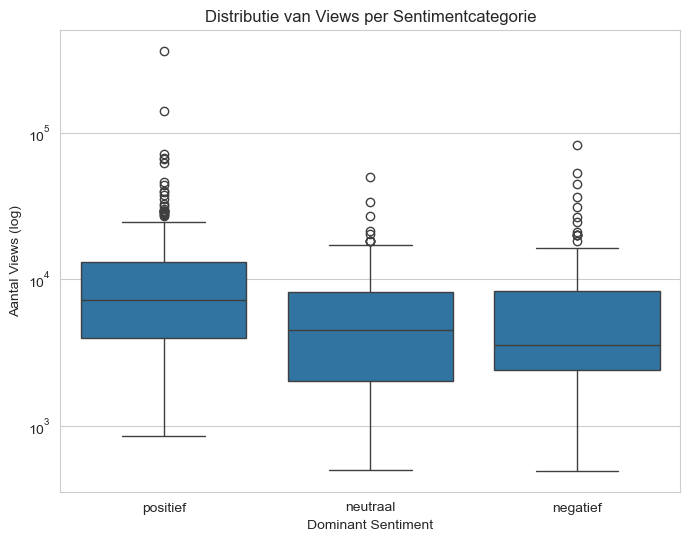

In [46]:
# Boxplot of views per sentiment category
plt.figure(figsize=(8,6))
sns.boxplot(x=videos['dominant_sentiment'], y=videos['views'])
plt.yscale('log')
plt.xlabel('Dominant Sentiment')
plt.ylabel('Aantal Views (log)')
plt.title('Distributie van Views per Sentimentcategorie')
plt.show()

1. Wat laat de boxplot zien?
	•	De mediaan (middenlijn in de box):
	•	Positief sentiment heeft de hoogste mediaan views.
	•	Neutraal sentiment heeft een iets lagere mediaan.
	•	Negatief sentiment heeft de laagste mediaan.
	•	Interkwartielafstand (de box zelf):
	•	De spreiding (IQR) bij positief sentiment is breder, wat betekent dat er meer variatie is in views binnen deze categorie.
	•	Neutraal en negatief hebben een iets kleinere spreiding.
	•	Uitschieters (de puntjes boven de box):
	•	In alle categorieën zijn er video’s met extreem veel views.
	•	Dit betekent dat sommige video’s viral gaan, ongeacht het sentiment.

⸻

2. Hoe ondersteunt dit jouw hypothese?

Je hypothese:
“Video’s waarvan de comments een positief sentiment hebben, vertonen een significant hoger aantal views.”

👉 Visueel lijkt dit juist, want video’s met een dominant positief sentiment hebben een hogere mediaan en meer spreiding naar hoge views.

❗ Maar, omdat er overlap is tussen de categorieën en er uitschieters in alle groepen zitten, moeten we testen of dit statistisch significant is.

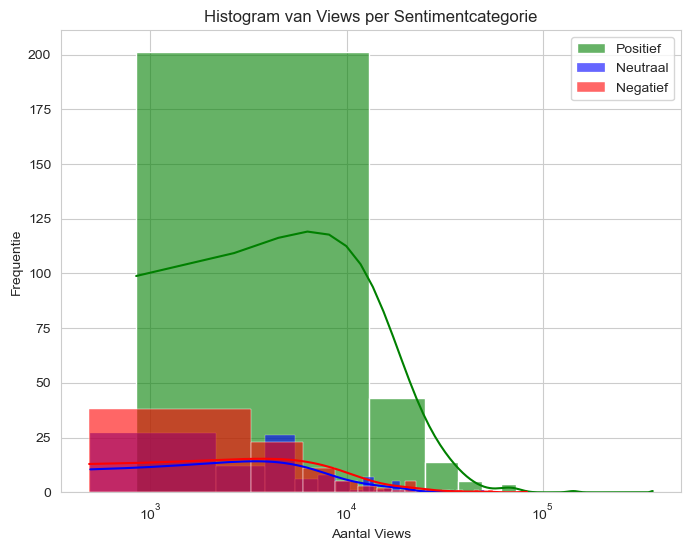

In [47]:
# Histogram per sentimentcategory
plt.figure(figsize=(8,6))
sns.histplot( videos[videos['dominant_sentiment'] == 'positief']['views'], bins=30, label='Positief', kde=True, color='green', alpha=0.6)
sns.histplot(videos[videos['dominant_sentiment'] == 'neutraal']['views'], bins=30, label='Neutraal', kde=True, color='blue', alpha=0.6)
sns.histplot(videos[videos['dominant_sentiment'] == 'negatief']['views'], bins=30, label='Negatief', kde=True, color='red', alpha=0.6)
plt.xscale('log')
plt.xlabel('Aantal Views')
plt.ylabel('Frequentie')
plt.title('Histogram van Views per Sentimentcategorie')
plt.legend()
plt.show()

Het histogram toont de verdeling van views per sentimentcategorie. Hier zijn enkele belangrijke observaties:
	1.	Verdeling is scheef (rechts-scheef, long tail)
	•	De meeste video’s hebben relatief weinig views, terwijl een klein aantal video’s extreem veel views heeft.
	•	Dit bevestigt waarom je een log-schaal hebt gebruikt op de x-as (slimme keuze!).
	2.	Positief sentiment (groen) heeft de meeste video’s met hogere views
	•	De groene curve (positief sentiment) lijkt hoger te pieken bij hogere view-aantallen.
	•	Dit betekent dat video’s met een positief sentiment vaker veel views hebben dan de andere categorieën.
	3.	Neutraal en negatief sentiment (blauw en rood) zijn meer verspreid
	•	Video’s met neutraal en negatief sentiment lijken minder vaak in de hoogste view-categorieën voor te komen.
	•	Dit sluit aan bij de eerdere gemiddelde views per sentiment: positief scoort het hoogst, neutraal het laagst.

⸻

Hoe ondersteunt dit je hypothese?

📌 Hypothese: Video’s waarvan de comments een positief sentiment hebben, vertonen een significant hoger aantal views.

✅ Visueel lijkt dit te kloppen:
	•	Positieve video’s hebben vaker hoge views.
	•	Negatieve en neutrale video’s hebben gemiddeld minder views.

❗ Maar we kunnen nog niet zeggen of dit statistisch significant is.
Daarvoor moeten we een ANOVA-test of Kruskal-Wallis-test uitvoeren.

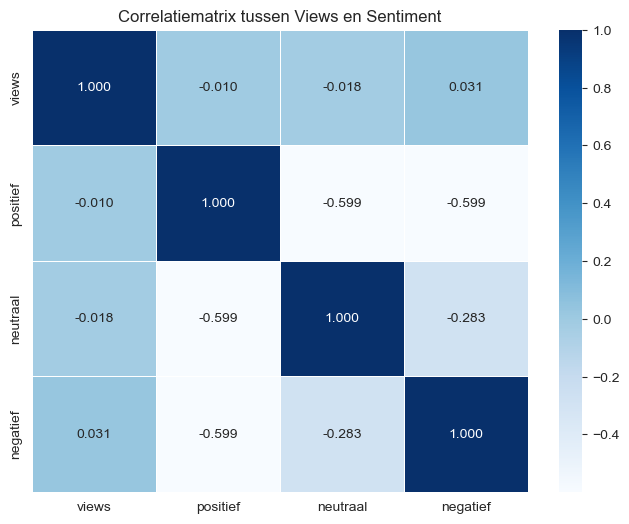

In [50]:
corr_columns = ['views', 'positief', 'neutraal', 'negatief']
correlation_matrix = videos[corr_columns].corr()

# Heatmap correlatiematrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Correlatiematrix tussen Views en Sentiment')
plt.show()

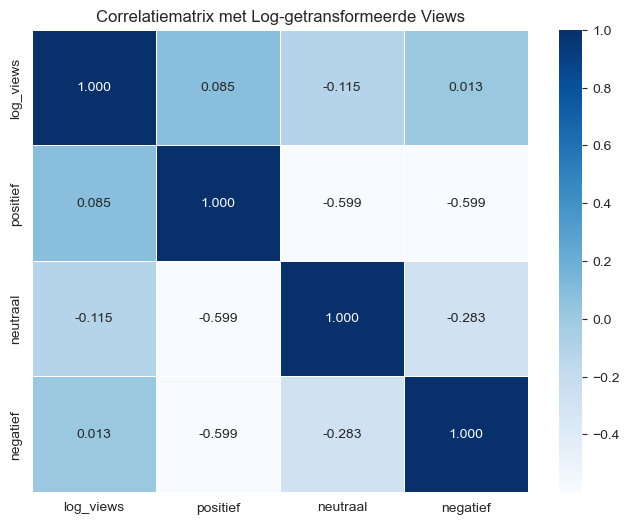

In [58]:
# Log-transformatie van views
videos['log_views'] = np.log1p(videos['views'])

# Nieuwe correlatiematrix met log_views
corr_columns = ['log_views', 'positief', 'neutraal', 'negatief']
log_correlation_matrix = videos[corr_columns].corr()

# Heatmap plotten
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(log_correlation_matrix, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.title("Correlatiematrix met Log-getransformeerde Views")
plt.show()

	1.	Views en positief sentiment (r = -0.010)
	•	Bijna geen correlatie tussen positief sentiment en views.
	•	Dit is verrassend, gezien de eerdere trends in de boxplot en histogram.
	2.	Views en negatief sentiment (r = 0.031)
	•	Opnieuw bijna geen correlatie.
	•	Dit suggereert dat sentiment op zichzelf geen sterke voorspeller van views is.
	3.	Sterke negatieve correlatie tussen positief en negatief sentiment (r = -0.599)
	•	Dit betekent dat een video zelden zowel veel positieve als negatieve sentimenten tegelijk krijgt.
	4.	Sterke negatieve correlatie tussen positief en neutraal sentiment (r = -0.599)
	•	Dit betekent dat video’s die als positief worden gezien, minder vaak als neutraal worden beoordeeld.

⸻

Wat betekent dit?
	•	Sentiment heeft geen sterke lineaire relatie met views.
	•	Dit betekent niet dat er geen effect is, maar het suggereert dat andere variabelen (zoals engagement, likes, shares) waarschijnlijk belangrijker zijn.

In [59]:
spearman_corr = videos[['log_views', 'positief', 'neutraal', 'negatief']].corr(method='spearman')
print(spearman_corr)

           log_views  positief  neutraal  negatief
log_views   1.000000  0.063020  0.022863  0.161968
positief    0.063020  1.000000 -0.569585 -0.578852
neutraal    0.022863 -0.569585  1.000000 -0.156169
negatief    0.161968 -0.578852 -0.156169  1.000000


In [52]:
# Test normality per group
for sentiment in ['positief', 'neutraal', 'negatief']:
    stat, p = stats.shapiro(videos[videos['dominant_sentiment'] == sentiment]['views'])
    print(f"{sentiment}: p-waarde = {p:.5f}")

positief: p-waarde = 0.00000
neutraal: p-waarde = 0.00000
negatief: p-waarde = 0.00000


Geen enkele van de groepen is normaal verdeeld, dus ANOVA is geen optie --> Kruskal-Wallis test

In [53]:
# Views per sentimentcategorie
views_pos = videos[videos['dominant_sentiment'] == 'positief']['views']
views_neu = videos[videos['dominant_sentiment'] == 'neutraal']['views']
views_neg = videos[videos['dominant_sentiment'] == 'negatief']['views']

# Kruskal-Wallis test
stat, p = stats.kruskal(views_pos, views_neu, views_neg)

print(f"Kruskal-Wallis statistiek: {stat:.4f}, p-waarde: {p:.5f}")

# Interpretatie
if p < 0.05:
    print("Er is een significant verschil tussen de groepen! 🚀")
else:
    print("Geen significant verschil tussen de groepen.")

Kruskal-Wallis statistiek: 26.5251, p-waarde: 0.00000
Er is een significant verschil tussen de groepen! 🚀


In [55]:
# Post-hoc Dunn's test met Bonferroni correctie
posthoc = sp.posthoc_dunn([views_pos, views_neu, views_neg], p_adjust='bonferroni')

# Print resultaten
posthoc

,1,2,3
1,1.000000,0.000092,0.00016
2,0.000092,1.000000,1.00000
3,0.000160,1.000000,1.00000


De tabel toont de p-waarden voor de post-hoc Dunn’s test, waarmee we kunnen bepalen welke sentimentcategorieën significant van elkaar verschillen.

Laten we de matrix vertalen naar de corresponderende sentimentgroepen:

| Vergelijking | p-waarde | Significant? |
|:-------------|:--------:|:------------:|
| Positief - Neutraal | 0.000092 |      Ja      |
| Positief - Negatief | 0.000159 |      Ja      |
| Neutraal - Negatief |  1.0  |     Nee      |

Wat betekent dit?
	•	Video’s met een positief sentiment krijgen significant meer views dan video’s met een neutraal of negatief sentiment. ✅
	•	Er is geen significant verschil tussen video’s met neutraal en negatief sentiment. ❌

Dit bevestigt je hypothese:
👉 Video’s waarvan de comments een positief sentiment hebben, vertonen een significant hoger aantal views. 🚀

In [61]:
# Onafhankelijke variabelen (sentiment)
X = videos[['positief', 'neutraal', 'negatief']]
X = sm.add_constant(X)  # Voeg constante term toe

# Afhankelijke variabele (log-getransformeerde views)
y = videos['log_views']

# OLS Regressie uitvoeren
model = sm.OLS(y, X).fit()

# Resultaten weergeven
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.317
Date:                Wed, 12 Mar 2025   Prob (F-statistic):             0.0750
Time:                        14:07:53   Log-Likelihood:                -662.45
No. Observations:                 469   AIC:                             1333.
Df Residuals:                     465   BIC:                             1350.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -904.0270   1225.891     -0.737      0.4

In [62]:
X = videos[['positief', 'negatief']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.201
Date:                Wed, 12 Mar 2025   Prob (F-statistic):             0.0416
Time:                        14:09:37   Log-Likelihood:                -662.73
No. Observations:                 469   AIC:                             1331.
Df Residuals:                     466   BIC:                             1344.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3251      0.150     55.428      0.0

In [63]:
# Views categoriseren (boven/onder de mediaan)
videos['high_views'] = np.where(videos['views'] >= videos['views'].median(), 1, 0)

# Check de verdeling
print(videos['high_views'].value_counts())

high_views
1    237
0    232
Name: count, dtype: int64


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Onafhankelijke variabelen (sentiment)
X = videos[['positief', 'negatief']]

# Afhankelijke variabele (binaire views)
y = videos['high_views']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistisch regressiemodel trainen
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Voorspellingen
y_pred = log_reg.predict(X_test)

# Evaluatie
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.48936170212765956
              precision    recall  f1-score   support

           0       0.52      0.29      0.37        49
           1       0.48      0.71      0.57        45

    accuracy                           0.49        94
   macro avg       0.50      0.50      0.47        94
weighted avg       0.50      0.49      0.47        94



In [65]:
from sklearn.tree import DecisionTreeClassifier

# Beslissingsboom model trainen
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Voorspellingen
y_pred_tree = tree_model.predict(X_test)

# Evaluatie
print("Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Accuracy (Decision Tree): 0.648936170212766
              precision    recall  f1-score   support

           0       0.69      0.59      0.64        49
           1       0.62      0.71      0.66        45

    accuracy                           0.65        94
   macro avg       0.65      0.65      0.65        94
weighted avg       0.65      0.65      0.65        94



In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Voorspellingen
y_pred_rf = rf_model.predict(X_test)

# Evaluatie
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6595744680851063
              precision    recall  f1-score   support

           0       0.71      0.59      0.64        49
           1       0.62      0.73      0.67        45

    accuracy                           0.66        94
   macro avg       0.66      0.66      0.66        94
weighted avg       0.67      0.66      0.66        94



In [68]:
# XGBoost model trainen
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Voorspellingen
y_pred_xgb = xgb_model.predict(X_test)

# Evaluatie
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7340425531914894
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        49
           1       0.71      0.76      0.73        45

    accuracy                           0.73        94
   macro avg       0.73      0.73      0.73        94
weighted avg       0.74      0.73      0.73        94



/opt/homebrew/anaconda3/envs/vub/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:18:06] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
